In [1]:
import numpy as np
import pandas as pd
from array import array
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns
import anndata as ad
import phagepy as pp
import scanpy as sc
import scipy.stats as ss
import scipy
import phagepy.analysis as analysis
import re
import os
from collections import Counter
import scipy.stats as stats
from Bio import SeqIO

In [2]:
# define output folder for figures
fig_dir='/path/to/output_figs/'

In [3]:
# define directory for source and output files
dir='/path/to/source_files/'

# Read/write

In [4]:
# load processed adata objects
## should be adata objects that have been subsetted to only include cohort-enriched peptides
subset_cbm_all = sc.read_h5ad(dir+'02_cbm_dshits.h5ad')
subset_bd_all = sc.read_h5ad(dir+'02_bd_dshits.h5ad')

In [12]:
# load processed adata objects
## this should be all peptides
cbm = sc.read_h5ad(dir+'01_cbm.h5ad')
bd = sc.read_h5ad(dir+'01_bd.h5ad')

In [5]:
# load chagas-specific peptide files
chagas_pept_cbm=pd.read_csv(dir+'01_cbm_pept.csv', index_col=0, header=0)
chagas_pept_bd=pd.read_csv(dir+'01_bd_pept.csv', index_col=0, header=0)

# Fig 4 - meme/fimo analysis

## Generate fasta for each antigen for motif discovery

In [6]:
# generate fastas of each antigen:
## first make a dict of each antigen: {ag_id : protein name string}
## make a new df that is a subset of chagas_pept_bd for all peptides with any protein name in their 'protein' column, but add new column that has 'ag_name' that is key from dict for given value
antigens = {'ag1' : 'cysteine peptidase',
            'ag2' : 'surface antigen',
            'ag13_SAPA' : 'trans-sialidase',
            'ag30' : 'r27',
            'ag36' : 'microtubule',
            'tce' : '60S'
           }

In [7]:
# make df of enriched peptides that belong to the protein family of each known antigen
filtered_dfs = []

# loop through the antigen dictionary
for key, value in antigens.items():
    # filter the df based on the protein name string
    filtered_df = chagas_pept_bd[chagas_pept_bd['protein'].str.contains(value, case=False, na=False)].copy()
    # add the 'ag_id' column with the current key
    filtered_df['ag_id'] = key
    # append to the list of filtered dfs
    filtered_dfs.append(filtered_df)

# concatenate all filtered dfs into a single df
antigen_df = pd.concat(filtered_dfs, ignore_index=False)
antigen_df.head()

,no_test,no_ctrl,perc_test,perc_ctrl,gene,protein,refseq_id,seq,stage,ag_id
peptide,,,,,,,,,,
XP_802556.1_calpain-like_cysteine_peptidase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag22,51,0,79.6875,0.0000,Tc00.1047053484311.10,"Calpain-like cysteine peptidase, putative",XP_802556.1,DKDPKFLAMEQERRQLLEKDPRRNAREIAALEESMNARAQELAREKK,NaN,ag1
XP_804109.1_calpain_cysteine_peptidase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag53,50,1,78.1250,1.5625,Tc00.1047053505985.9,"Calpain cysteine peptidase, putative",XP_804109.1,DSDFVAMEQERRQLLEKDPRRNAREIAALEESMNARAQELAREKKLA,ama_tryp_meta_epi,ag1
XP_804109.1_calpain_cysteine_peptidase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag55,49,0,76.5625,0.0000,Tc00.1047053505985.9,"Calpain cysteine peptidase, putative",XP_804109.1,EGVPLRELPLDDDSDFVAMEQERRQLLEKDPRRNAREIAALEESMNA,ama_tryp_meta_epi,ag1
XP_804109.1_calpain_cysteine_peptidase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag48,41,1,64.0625,1.5625,Tc00.1047053505985.9,"Calpain cysteine peptidase, putative",XP_804109.1,QLNTDQKFLAMEQERRQLLEKDPRRNAKEIAALEESMNARAQELARE,ama_tryp_meta_epi,ag1
XP_804109.1_calpain_cysteine_peptidase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag50,35,1,54.6875,1.5625,Tc00.1047053505985.9,"Calpain cysteine peptidase, putative",XP_804109.1,DQKPEGVPLRELPLDDDSDFVAMEQERRQLLEKDPRRNAKEIAALEE,ama_tryp_meta_epi,ag1


In [8]:
# inspect how many enriched peptides belong to each protein name
antigen_df['ag_id'].value_counts()

ag_id
ag13_SAPA    909
tce           86
ag1           50
ag2           25
ag30          21
ag36          20
Name: count, dtype: int64

In [9]:
# now make fasta for each ag_id and move to meme and fimo in command line

In [10]:
def generate_fasta_agid(df, output_dir):
    """
    Generate a FASTA file for each unique 'ag_id' in the DataFrame.
    
    Parameters:
    - df: DataFrame containing columns 'ag_id' and 'seq' (among others).
    - output_dir: Directory where the FASTA files will be saved.
    """
    # ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # group the df by 'ag_id'
    grouped = df.groupby('ag_id')
    
    for ag_id, group in grouped:
        # define the filename for this ag_id
        filename = os.path.join(output_dir, f"{ag_id}.fasta")
        
        # generate the FASTA file
        with open(filename, 'w') as fasta_file:
            for peptide, seq_row in group.iterrows():
                # extract refseq id and fragment number from the peptide index for fasta headings
                match = re.match(r'(XP_\d+\.\d+).*_(frag\d+)', peptide)
                if match:
                    id_part, frag_part = match.groups()
                    header = f'>{id_part}_{frag_part}\n'
                else:
                    # default header if the pattern does not match
                    header = f'>{peptide}\n'
                
                sequence = f'{seq_row["seq"]}\n'
                fasta_file.write(header)
                fasta_file.write(sequence)

In [11]:
generate_fasta_agid(antigen_df, dir)

## Import fimo data for antigens

In [13]:
# did meme and fimo, got list of peptides with strong motif match
# import in list of peptides and make list of unique peptide ids
ag1 = pd.read_csv(dir+'fimo_ag1.tsv', sep = '\t', index_col=1)
ag2 = pd.read_csv(dir+'fimo_ag2.tsv', sep = '\t', index_col=1)
ag13 = pd.read_csv(dir+'fimo_ag13.tsv', sep = '\t', index_col=1)
ag30 = pd.read_csv(dir+'fimo_ag30.tsv', sep = '\t', index_col=1)
ag36 = pd.read_csv(dir+'fimo_ag36.tsv', sep = '\t', index_col=1)
sapa = pd.read_csv(dir+'fimo_sapa.tsv', sep = '\t', index_col=1)
tce = pd.read_csv(dir+'fimo_tce.tsv', sep = '\t', index_col=1)
ts2_23 = pd.read_csv(dir+'fimo_ts2_23.tsv', sep = '\t', index_col=1)

# fimo output files have command info in last 3 lines - drop this for ease of plotting
ag1.drop(ag1.tail(3).index,inplace=True)
ag2.drop(ag2.tail(3).index,inplace=True)
ag13.drop(ag13.tail(3).index,inplace=True)
ag30.drop(ag30.tail(3).index,inplace=True)
ag36.drop(ag36.tail(3).index,inplace=True)
sapa.drop(sapa.tail(3).index,inplace=True)
tce.drop(tce.tail(3).index,inplace=True)
ts2_23.drop(ts2_23.tail(3).index,inplace=True)
ag2.tail()

,motif_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
motif_alt_id,,,,,,,,,
MEME-1,DKPSPFGQAAAGDKP,XP_813516.1_surface_antigen_2_(CA-2)_[Trypanos...,25.0,39.0,+,23.6000,9.540000e-12,0.000001,DRPPLFVPIAAGDKP
MEME-1,DKPSPFGQAAAGDKP,XP_813516.1_surface_antigen_2_(CA-2)_[Trypanos...,3.0,17.0,+,22.2375,1.530000e-11,0.000002,ERPTQMMYAVGYTPH
MEME-1,DKPSPFGQAAAGDKP,XP_813516.1_surface_antigen_2_(CA-2)_[Trypanos...,31.0,45.0,+,22.2375,1.530000e-11,0.000002,ERPTQMMYAVGYTPH
MEME-1,DKPSPFGQAAAGDKP,XP_813516.1_surface_antigen_2_(CA-2)_[Trypanos...,17.0,31.0,+,21.4125,2.020000e-11,0.000003,DRPPLFVPIAAGDKQ
MEME-1,DKPSPFGQAAAGDKP,XP_813516.1_surface_antigen_2_(CA-2)_[Trypanos...,9.0,23.0,+,11.7125,5.300000e-10,0.000068,QKTEPFGQAAADDKP


In [14]:
# generate unified df with column specifying which peptide maps to which antigen
dfs = {'ag1': ag1, 'ag2': ag2, 'ag13': ag13, 'ag30': ag30, 'ag36': ag36, 'sapa': sapa, 'tce': tce, 'ts2_ts23': ts2_23}

# add 'ag_id' column and concatenate
ag_df = pd.concat([df.assign(ag_id=name) for name, df in dfs.items()], ignore_index=True)
ag_df.head()

,motif_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,ag_id
0,DSDFVAMEQERRQLL,XP_804109.1_calpain_cysteine_peptidase_partial...,1.0,15.0,+,51.8824,6.250000e-19,8.860000e-13,DSDFVAMEQERRQLL,ag1
1,DSDFVAMEQERRQLL,XP_804109.1_calpain_cysteine_peptidase_partial...,13.0,27.0,+,51.8824,6.250000e-19,8.860000e-13,DSDFVAMEQERRQLL,ag1
2,DSDFVAMEQERRQLL,XP_804109.1_calpain_cysteine_peptidase_partial...,17.0,31.0,+,51.8824,6.250000e-19,8.860000e-13,DSDFVAMEQERRQLL,ag1
3,DSDFVAMEQERRQLL,XP_804989.1_calpain_cysteine_peptidase_partial...,20.0,34.0,+,51.8824,6.250000e-19,8.860000e-13,DSDFVAMEQERRQLL,ag1
4,DSDFVAMEQERRQLL,XP_804109.1_calpain_cysteine_peptidase_partial...,29.0,43.0,+,51.8824,6.250000e-19,8.860000e-13,DSDFVAMEQERRQLL,ag1


In [15]:
# add KMP-11 peptides to df
kmp11 = pd.DataFrame([['kmp11', 'XP_808865.1_kinetoplastid_membrane_protein_KMP-11_[Trypanosoma_cruzi_strain_CL_Brener]_frag2', 0, 0, 0, 0, 0, 0, 0, 'kmp11'],
                     ['kmp11', 'XP_808865.1_kinetoplastid_membrane_protein_KMP-11_[Trypanosoma_cruzi_strain_CL_Brener]_frag3', 0, 0, 0, 0, 0, 0, 0, 'kmp11'],
                     ['kmp11', 'XP_808865.1_kinetoplastid_membrane_protein_KMP-11_[Trypanosoma_cruzi_strain_CL_Brener]_frag1', 0, 0, 0, 0, 0, 0, 0, 'kmp11']], columns=['motif_id', 'sequence_name', 'start','stop','strand','score','p-value','q-value','matched_sequence', 'ag_id'])
ag_df = pd.concat([kmp11, ag_df])
ag_df.head()

,motif_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,ag_id
0,kmp11,XP_808865.1_kinetoplastid_membrane_protein_KMP...,0.0,0.0,0,0.0000,0.000000e+00,0.000000e+00,0,kmp11
1,kmp11,XP_808865.1_kinetoplastid_membrane_protein_KMP...,0.0,0.0,0,0.0000,0.000000e+00,0.000000e+00,0,kmp11
2,kmp11,XP_808865.1_kinetoplastid_membrane_protein_KMP...,0.0,0.0,0,0.0000,0.000000e+00,0.000000e+00,0,kmp11
0,DSDFVAMEQERRQLL,XP_804109.1_calpain_cysteine_peptidase_partial...,1.0,15.0,+,51.8824,6.250000e-19,8.860000e-13,DSDFVAMEQERRQLL,ag1
1,DSDFVAMEQERRQLL,XP_804109.1_calpain_cysteine_peptidase_partial...,13.0,27.0,+,51.8824,6.250000e-19,8.860000e-13,DSDFVAMEQERRQLL,ag1


In [16]:
ag_df.shape

(706, 10)

In [17]:
# check if there are duplicated peptide ids (e.g., a motif was repeated in a peptide and so that peptide was scored multiple times in fimo analysis)
ag_df['sequence_name'].is_unique

False

In [18]:
# generate list of unique 'sequence_name's
list_ag = ag_df['sequence_name'].str.split(r',\s*').explode().unique().tolist()
len(list_ag)

340

In [19]:
# some peptides may have not been enriched in any samples and were dropped from the bd set in early processing
# drop these from the final set of peptides to plot
filt_list_ag = [gene for gene in list_ag if gene in bd.var_names]
len(filt_list_ag)

337

In [20]:
# subset ag_df to unique peptides with sequencing data
ag_df = ag_df[ag_df['sequence_name'].isin(filt_list_ag)]

In [21]:
# generate subsetted adata object with only the peptides with sequence similarity to known antigens
subset_bd_ags = bd[bd.obs['sero'].isin(['seropositive']), filt_list_ag]
subset_bd_ags

View of AnnData object with n_obs × n_vars = 64 × 337
    obs: 'plate_well', 'BirthReg', 'birth_country', 'sero', 'group', 'region'
    var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'
    obsm: 'DS_z_5'
    layers: 'z_score'

In [22]:
ag_df_plot = pd.DataFrame(data=subset_bd_ags.layers['z_score'], 
                             index=subset_bd_ags.obs.index, 
                             columns=filt_list_ag)
ag_df_plot = ag_df_plot.T
sorted_obs = subset_bd_ags.obs.sort_values(by=['group', 'region'], ascending=True)
ag_df_plot = ag_df_plot[sorted_obs.index]
ag_df_plot.head()

,tclib_C7_S1217_R1_001,tclib_D2_S1224_R1_001,tclib_E11_S1245_R1_001,tclib_E3_S1237_R1_001,tclib_F5_S1251_R1_001,tclib_G1_S1259_R1_001,tclib_G5_S1263_R1_001,tclib_G9_S1267_R1_001,tclib_H2_S1272_R1_001,tclib_H6_S1276_R1_001,...,tclib_E9_S1243_R1_001,tclib_F12_S1258_R1_001,tclib_F2_S1248_R1_001,tclib_G12_S1270_R1_001,tclib_G4_S1262_R1_001,tclib_G6_S1264_R1_001,tclib_H12_S1282_R1_001,tclib_H1_S1271_R1_001,tclib_H4_S1274_R1_001,tclib_H5_S1275_R1_001
XP_808865.1_kinetoplastid_membrane_protein_KMP-11_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,0.080604,1.358998,-0.334044,-0.556563,4.514199,-0.556563,-0.110852,11.294765,0.730908,0.324061,...,-0.556563,0.299129,-0.556563,-0.556563,1.128046,-0.134634,0.292052,-0.345742,0.752495,1.192534
XP_808865.1_kinetoplastid_membrane_protein_KMP-11_[Trypanosoma_cruzi_strain_CL_Brener]_frag3,0.172717,1.583205,-0.764291,-0.299929,0.167833,0.691825,-0.272699,0.661668,-0.764291,-0.278653,...,-0.764291,0.651374,-0.301461,-0.764291,-0.764291,1.562520,-0.764291,-0.764291,-0.764291,-0.282004
XP_808865.1_kinetoplastid_membrane_protein_KMP-11_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,0.796872,0.475274,-0.485073,-0.824899,1.433744,-0.824899,0.196116,2.465827,-0.824899,0.183749,...,-0.500035,-0.171504,-0.824899,-0.824899,0.783030,10.129186,-0.824899,0.140984,-0.824899,-0.491003
XP_804109.1_calpain_cysteine_peptidase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag53,275.966034,-0.627629,296.211792,32.124584,32.244488,109.682251,567.621155,617.103088,957.647156,850.618713,...,3.662637,121.410301,-0.627629,46.641220,31.527996,-0.019799,29.323893,54.647408,665.067871,353.395935
XP_804109.1_calpain_cysteine_peptidase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag55,216.218140,-0.895480,90.692032,8.418235,13.875950,38.644211,393.595520,425.920502,536.946838,537.097351,...,0.798874,61.964825,-1.083857,19.952036,5.066455,0.036445,3.234840,69.633980,768.225647,214.677078


In [24]:
# add in antigen information from fimo
ag_df_plot = ag_df_plot.join(ag_df.set_index('sequence_name'), how='inner')

# group by 'ag_id' and extract the max z-score for each antigen for each person
grouped_max = ag_df_plot.groupby('ag_id').max()

# rename the index to 'ag_id'
grouped_max.index.name = 'ag_id'

grouped_max.head()

,tclib_C7_S1217_R1_001,tclib_D2_S1224_R1_001,tclib_E11_S1245_R1_001,tclib_E3_S1237_R1_001,tclib_F5_S1251_R1_001,tclib_G1_S1259_R1_001,tclib_G5_S1263_R1_001,tclib_G9_S1267_R1_001,tclib_H2_S1272_R1_001,tclib_H6_S1276_R1_001,...,tclib_H4_S1274_R1_001,tclib_H5_S1275_R1_001,motif_id,start,stop,strand,score,p-value,q-value,matched_sequence
ag_id,,,,,,,,,,,,,,,,,,,,,
ag1,275.966034,3.984265,296.211792,32.124584,43.277893,109.682251,567.621155,617.103088,957.647156,850.618713,...,768.225647,353.395935,EKDPRRNAKKIADLE,37.0,47.0,+,52.0000,4.570000e-10,9.990000e-05,SRLNDRAHELA
ag13,16.341547,30.373663,29.758739,14.151079,21.149195,185.282242,41.619709,21.597847,100.329285,24.431602,...,35.278316,24.885145,AEPKPAEPKS,38.0,47.0,+,37.2154,3.090000e-09,8.760000e-05,GEPKPAEPKP
ag2,643.375732,450.126099,959.534119,56.233322,461.265533,223.090179,1144.282349,911.239746,453.809906,640.512451,...,768.174927,655.022217,DKPSPFGQAAAGDKP,33.0,47.0,+,58.1000,5.300000e-10,6.750000e-05,QKTEPFGQAAADDKP
ag30,1.048308,1.110993,45.872131,8.812078,3.310436,0.299693,31.105511,2.671476,0.795290,47.075077,...,2.656773,3.030450,RKAAEATKVAEAEKQ,32.0,46.0,+,57.0494,1.640000e-10,2.400000e-05,RNAAEATKVAEAEKR
ag36,86.591492,9.404217,346.787079,54.650059,14.801983,226.800171,495.184570,1147.648438,1205.632812,292.470184,...,2400.483398,223.833405,TTQDAYRPVDPSAYK,33.0,47.0,+,64.1500,3.990000e-14,2.490000e-08,VSHESYKSVDSSAYK


In [25]:
grouped_max = grouped_max.drop(columns=['motif_id', 'start','stop','strand','score','p-value','q-value','matched_sequence'])
grouped_max.head()

,tclib_C7_S1217_R1_001,tclib_D2_S1224_R1_001,tclib_E11_S1245_R1_001,tclib_E3_S1237_R1_001,tclib_F5_S1251_R1_001,tclib_G1_S1259_R1_001,tclib_G5_S1263_R1_001,tclib_G9_S1267_R1_001,tclib_H2_S1272_R1_001,tclib_H6_S1276_R1_001,...,tclib_E9_S1243_R1_001,tclib_F12_S1258_R1_001,tclib_F2_S1248_R1_001,tclib_G12_S1270_R1_001,tclib_G4_S1262_R1_001,tclib_G6_S1264_R1_001,tclib_H12_S1282_R1_001,tclib_H1_S1271_R1_001,tclib_H4_S1274_R1_001,tclib_H5_S1275_R1_001
ag_id,,,,,,,,,,,,,,,,,,,,,
ag1,275.966034,3.984265,296.211792,32.124584,43.277893,109.682251,567.621155,617.103088,957.647156,850.618713,...,6.163876,121.410301,8.407063,46.641220,31.527996,7.913645,29.323893,88.749306,768.225647,353.395935
ag13,16.341547,30.373663,29.758739,14.151079,21.149195,185.282242,41.619709,21.597847,100.329285,24.431602,...,43.280693,34.602745,7.290048,15.582108,28.575003,12.987510,15.311982,9.822773,35.278316,24.885145
ag2,643.375732,450.126099,959.534119,56.233322,461.265533,223.090179,1144.282349,911.239746,453.809906,640.512451,...,1704.782593,1460.681519,2.826918,440.661804,184.115875,229.397125,212.905334,424.270782,768.174927,655.022217
ag30,1.048308,1.110993,45.872131,8.812078,3.310436,0.299693,31.105511,2.671476,0.795290,47.075077,...,66.539467,1.713138,1.365519,3.649216,7.508817,1.872445,17.947384,6.722246,2.656773,3.030450
ag36,86.591492,9.404217,346.787079,54.650059,14.801983,226.800171,495.184570,1147.648438,1205.632812,292.470184,...,4.438506,875.331299,10.677925,31.387686,43.964230,23.973396,45.876442,376.767853,2400.483398,223.833405


In [26]:
# figure out seroprevalence for each ag - define seropositive as z>= 5
percent_df = pd.DataFrame({'seropos': (grouped_max >= 5).sum(axis=1) / grouped_max.shape[1] * 100})
percent_df = percent_df.reindex(["ts2_ts23", "ag2", "tce", "ag1", "sapa", "ag13", "ag36", "ag30", "kmp11"])
percent_df

,seropos
ag_id,
ts2_ts23,100.0000
ag2,98.4375
tce,98.4375
ag1,95.3125
sapa,95.3125
ag13,93.7500
ag36,89.0625
ag30,46.8750
kmp11,6.2500


In [27]:
# re-order antigens in max-values df for plotting
grouped_max = grouped_max.reindex(percent_df.index)
# replace z-scores below 5 with 0
grouped_max = grouped_max.where(grouped_max > 5, 0)
grouped_max

,tclib_C7_S1217_R1_001,tclib_D2_S1224_R1_001,tclib_E11_S1245_R1_001,tclib_E3_S1237_R1_001,tclib_F5_S1251_R1_001,tclib_G1_S1259_R1_001,tclib_G5_S1263_R1_001,tclib_G9_S1267_R1_001,tclib_H2_S1272_R1_001,tclib_H6_S1276_R1_001,...,tclib_E9_S1243_R1_001,tclib_F12_S1258_R1_001,tclib_F2_S1248_R1_001,tclib_G12_S1270_R1_001,tclib_G4_S1262_R1_001,tclib_G6_S1264_R1_001,tclib_H12_S1282_R1_001,tclib_H1_S1271_R1_001,tclib_H4_S1274_R1_001,tclib_H5_S1275_R1_001
ag_id,,,,,,,,,,,,,,,,,,,,,
ts2_ts23,117.266693,485.812531,1739.833618,191.369949,44.517937,363.670288,286.664551,576.430237,598.374146,163.568817,...,292.927734,465.120728,9.294214,36.111206,96.914146,353.378815,749.691223,145.254913,876.497314,354.341156
ag2,643.375732,450.126099,959.534119,56.233322,461.265533,223.090179,1144.282349,911.239746,453.809906,640.512451,...,1704.782593,1460.681519,0.000000,440.661804,184.115875,229.397125,212.905334,424.270782,768.174927,655.022217
tce,38.531425,75.235321,299.434357,0.000000,35.317375,150.262314,182.213104,352.956543,169.683075,262.806122,...,119.870583,34.754925,18.664778,72.466751,55.685421,102.350655,8.017946,10.723069,504.692200,269.547791
ag1,275.966034,0.000000,296.211792,32.124584,43.277893,109.682251,567.621155,617.103088,957.647156,850.618713,...,6.163876,121.410301,8.407063,46.641220,31.527996,7.913645,29.323893,88.749306,768.225647,353.395935
sapa,20.123854,89.784737,570.811401,22.076187,52.004177,90.448654,37.806496,47.924046,1479.822876,196.015503,...,228.583496,88.523094,17.294863,83.829651,68.278877,9.902264,25.173328,59.751110,6.829230,102.841370
ag13,16.341547,30.373663,29.758739,14.151079,21.149195,185.282242,41.619709,21.597847,100.329285,24.431602,...,43.280693,34.602745,7.290048,15.582108,28.575003,12.987510,15.311982,9.822773,35.278316,24.885145
ag36,86.591492,9.404217,346.787079,54.650059,14.801983,226.800171,495.184570,1147.648438,1205.632812,292.470184,...,0.000000,875.331299,10.677925,31.387686,43.964230,23.973396,45.876442,376.767853,2400.483398,223.833405
ag30,0.000000,0.000000,45.872131,8.812078,0.000000,0.000000,31.105511,0.000000,0.000000,47.075077,...,66.539467,0.000000,0.000000,0.000000,7.508817,0.000000,17.947384,6.722246,0.000000,0.000000
kmp11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.294765,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,10.129186,0.000000,0.000000,0.000000,0.000000


In [28]:
# sort columns by reactivity to Ag2
grouped_max = grouped_max.loc[:, grouped_max.loc['ag2'].sort_values(ascending=False).index]
grouped_max.head()

,tclib_E8_S1242_R1_001,tclib_E9_S1243_R1_001,tclib_F10_S1256_R1_001,tclib_F12_S1258_R1_001,tclib_E7_S1241_R1_001,tclib_G7_S1265_R1_001,tclib_D10_S1232_R1_001,tclib_G5_S1263_R1_001,tclib_A7_S1193_R1_001,tclib_E11_S1245_R1_001,...,tclib_E1_S1235_R1_001,tclib_B12_S1210_R1_001,tclib_A12_S1198_R1_001,tclib_D9_S1231_R1_001,tclib_C5_S1215_R1_001,tclib_B8_S1206_R1_001,tclib_E3_S1237_R1_001,tclib_D1_S1223_R1_001,tclib_C6_S1216_R1_001,tclib_F2_S1248_R1_001
ag_id,,,,,,,,,,,,,,,,,,,,,
ts2_ts23,1294.498901,292.927734,531.799316,465.120728,1045.499390,28.943768,569.149353,286.664551,218.459732,1739.833618,...,17.143032,53.271076,24.012112,31.814964,14.202667,40.203766,191.369949,10.912535,813.934814,9.294214
ag2,1887.047607,1704.782593,1554.545410,1460.681519,1255.802856,1249.382935,1159.389893,1144.282349,1000.073303,959.534119,...,96.509354,91.058189,77.558121,76.765121,76.592743,59.788265,56.233322,28.154388,6.886386,0.000000
tce,19.856010,119.870583,18.388338,34.754925,99.714249,108.496933,152.160904,182.213104,108.522469,299.434357,...,13.804660,88.236298,5.268193,22.088989,103.156372,72.078117,0.000000,7.791688,214.565994,18.664778
ag1,747.078735,6.163876,747.847595,121.410301,138.720520,135.158524,17.548508,567.621155,187.511139,296.211792,...,0.000000,21.806379,7.152695,0.000000,7.199784,10.254086,32.124584,5.829156,111.530807,8.407063
sapa,153.325684,228.583496,109.709465,88.523094,11.134465,23.422153,21.041788,37.806496,60.449120,570.811401,...,57.334229,11.296711,19.924732,0.000000,25.428949,131.764023,22.076187,0.000000,1000.998291,17.294863


In [30]:
# create custom cmap
colors = ["#ebf3fb", "#08345e"]

custom_cmap = LinearSegmentedColormap.from_list("smooth_cmap", colors, N=256)

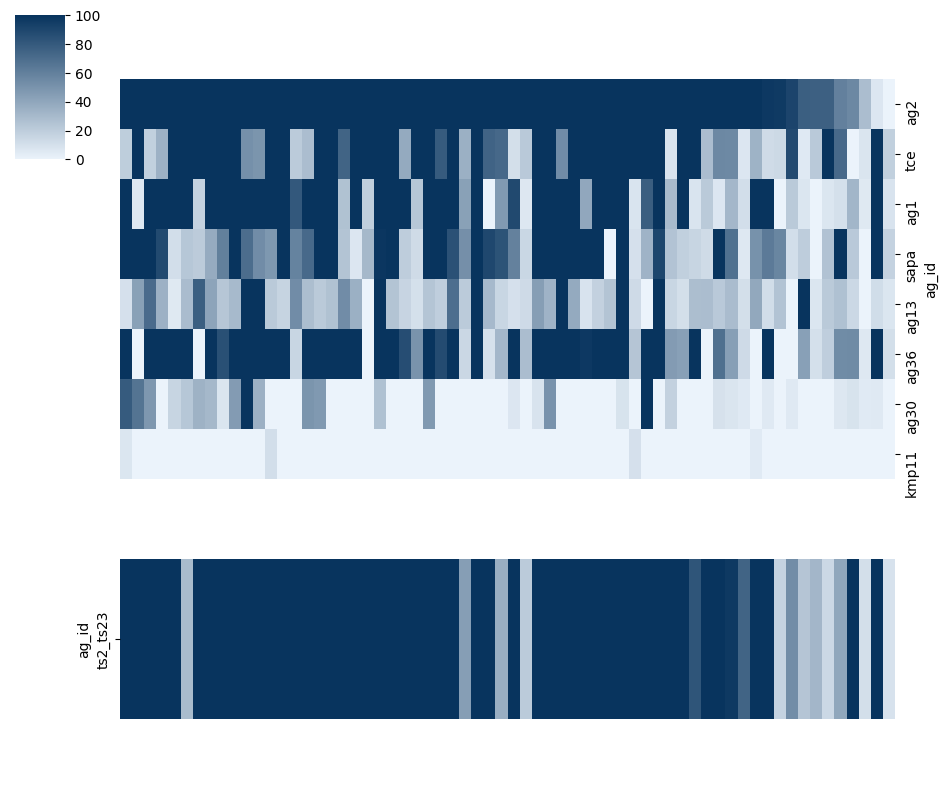

In [31]:
# plot maximum z-scores for each antigen
# subset out ts.2-23 for comparison
row_ts2_23 = grouped_max.loc[['ts2_ts23']]
main_data = grouped_max.drop(index='ts2_ts23')

clustermap = sns.clustermap(main_data, standard_scale=None, figsize=(10, 8), cbar_kws=None,
                            row_cluster=False,
                            col_cluster=False, row_colors=None, vmin=0, vmax=100,
                            mask=None, dendrogram_ratio=0.05, colors_ratio=0.02,
                            yticklabels=True, xticklabels=False, cmap=custom_cmap)

fig = clustermap.fig

# add a new axis for ts-2.23 heatmap
ax_bottom = fig.add_axes([0.125, 0.1, 0.775, 0.2])

# plot ts-2.23 heatmap
sns.heatmap(row_ts2_23, cbar=False, ax=ax_bottom, cmap=custom_cmap,
            vmin=0, vmax=100, xticklabels=False, yticklabels=True)

clustermap.ax_heatmap.set_position([0.125, 0.4, 0.775, 0.5])

# save and show plot
plt.savefig(fig_dir + 'fig_4a.pdf', dpi=300, bbox_inches="tight")
plt.show()